In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import ipywidgets

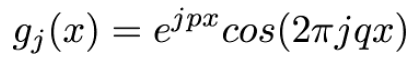

In [2]:
def kernel_function(x, j, p, q): 
    return (
        np.exp(j*p*x) * 
        np.cos(2*np.pi*j*q*x)
    )

In [3]:
n_cells = 100
x_nodes = np.linspace(0, 1, n_cells+1) 

In [4]:
x_nodes[:10]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [5]:
n_kernels = 30

p = -0.05
q = 0.1

j0=1
jN=30

j_values = np.linspace(j0, jN, n_kernels)

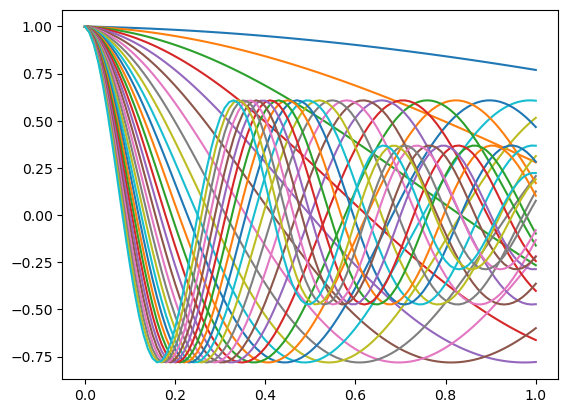

In [6]:
fig, ax = plt.subplots(1, 1) 

for jk in j_values: 
    kernel = kernel_function(x_nodes, jk, p, q)
    ax.plot(x_nodes, kernel)

## define our model 

In [7]:
# x_cells = 0.5*(x_nodes[1:] + x_nodes[:-1])
dx = np.diff(x_nodes)
x_cells = x_nodes[:-1] + dx/2

(0.0, 0.2)

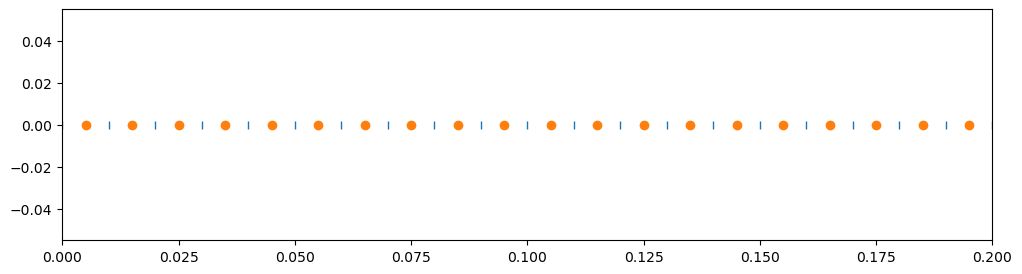

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(x_nodes, np.zeros_like(x_nodes), "|")
ax.plot(x_cells, np.zeros_like(x_cells), "o")
ax.set_xlim([0, 0.2])

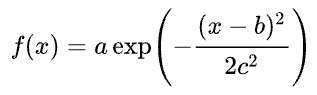

In [9]:
def build_model(
    x_cells, 
    x_boxcar_min=0.3, x_boxcar_max=0.5, amplitude_boxcar=0.5,
    gaussian_mean=0.7, gaussian_std=0.05, amplitude_gaussian=1
):

    model = np.zeros_like(x_cells)  # np.zeros(len(x_cells)) 
    
    # define a boxcar 
    inds_boxcar = (
        (x_cells < x_boxcar_max) & 
        (x_cells > x_boxcar_min)
    )
    model[inds_boxcar] = amplitude_boxcar 
    
    # add a gaussian 
    gaussian = amplitude_gaussian * np.exp(
        - (x_cells-gaussian_mean)**2 / (2*gaussian_std**2) 
    )
    
    model = model + gaussian
    return model


In [10]:
model = build_model(x_cells)

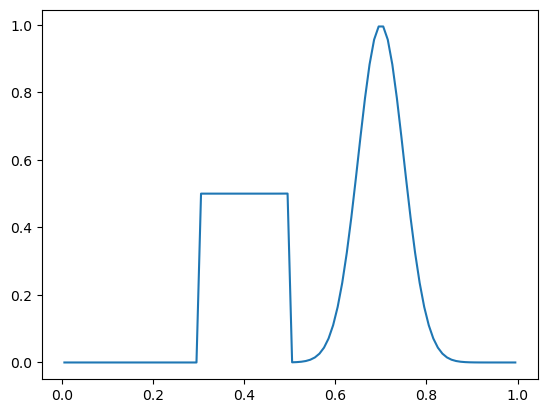

In [11]:
fig, ax = plt.subplots(1, 1) 

ax.plot(x_cells, model) 

In [12]:
def get_G(x_nodes, n_kernels, p=-0.05, q=0.1, j0=1, jN=30): 
    
    j_values = np.linspace(j0, jN, n_kernels)

    n_nodes = len(x_nodes) 
    n_cells = n_nodes - 1

    # fill an empty matrix with kernels on nodes 
    Gnodes = np.zeros((n_cells+1, n_kernels))
    for k, jk in enumerate(j_values):
        Gnodes[:, k] = kernel_function(x_nodes, jk, p, q)

    # averaging matrix from nodes to cells
    Ave = sp.spdiags([0.5*np.ones(n_nodes), 0.5*np.ones(n_nodes)], [0, 1], n_cells, n_nodes)

    # average Gnodes to cells
    Gcells = Ave @ Gnodes

    # integrate with delta x
    dx = np.diff(x_nodes)
    Deltax = sp.spdiags([dx], [0], n_cells, n_cells)

    # construct the full G matrix (N Data x N Cells) 
    G = (Ave @ Gnodes).T @ Deltax

    return G

In [13]:
# plt.plot(x_nodes, Gnodes);

In [14]:
# Gnodes.shape

In [15]:
# Ave.todense()

In [16]:
# plt.spy(ave)
# plt.matshow(ave.todense())

In [17]:
G = get_G(x_nodes, n_kernels)

In [18]:
G.shape

(30, 100)

In [19]:
data = G @ model

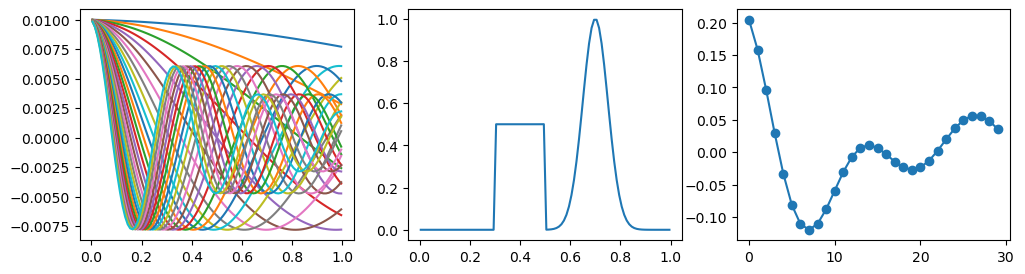

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3)) 

ax[0].plot(x_cells, G.T)
ax[1].plot(x_cells, model)
ax[2].plot(data, "-o")

# run inversion with data misfit only

In [21]:
G.shape

(30, 100)

In [22]:
# treat Wd as the identity for now

A = G.T @ G # + np.eye(len(x_cells)) * 1e-6
rhs = G.T @ data

In [23]:
m_hat = np.linalg.solve(A, rhs)

In [24]:
# m_hat = Ainv @ rhs

In [25]:
m_hat.shape

(100,)

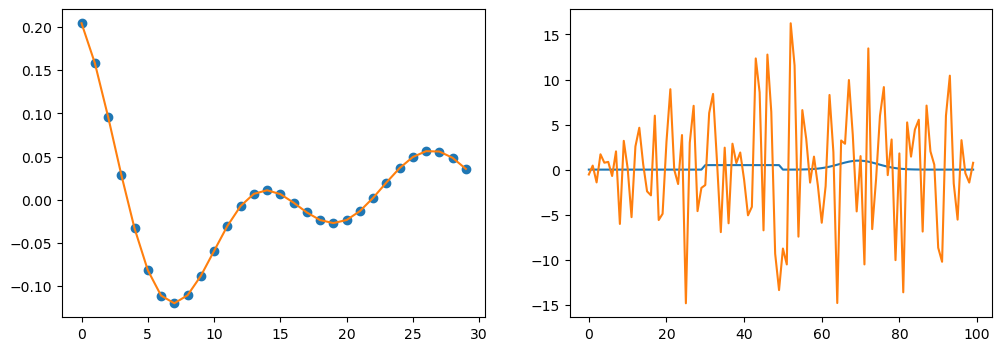

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(data, "o", label="observed data")
ax[0].plot(G @ m_hat, "-", label="predicted data")

ax[1].plot(model)
ax[1].plot(m_hat)

In [27]:
A.shape

(100, 100)

In [28]:
np.linalg.det(A)

np.float64(-0.0)

In [29]:
eigvals, eigvecs = np.linalg.eig(A)

/Users/lindseyjh/miniforge3/envs/eosc-454/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/lindseyjh/miniforge3/envs/eosc-454/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


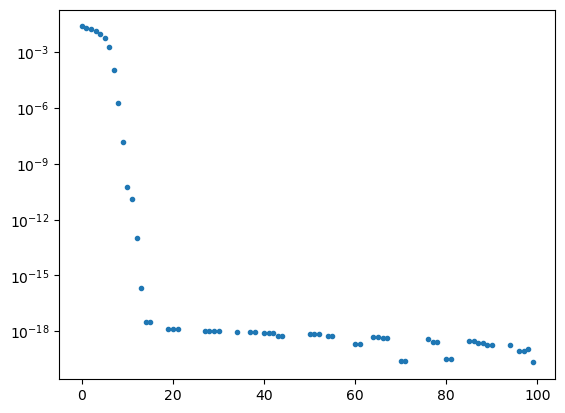

In [30]:
plt.semilogy(eigvals, ".")

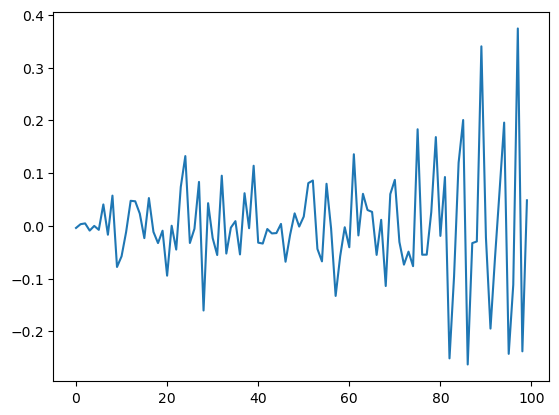

In [31]:
plt.plot(eigvecs[:, -1])

# inversion with regularization 

In [32]:
noise_level = 0.01
dobs = data + noise_level * np.random.randn(n_kernels) 

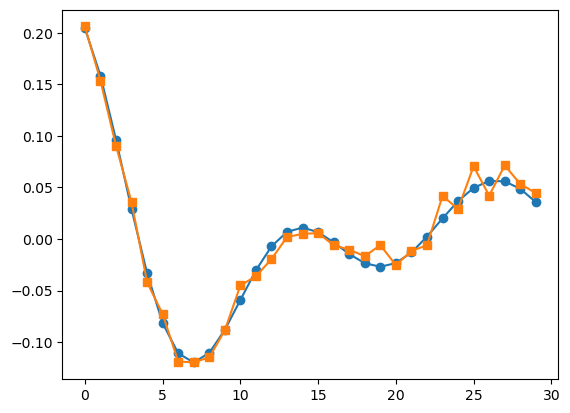

In [33]:
plt.plot(data, "-o", label="clean")
plt.plot(dobs, "-s", label="noisy")

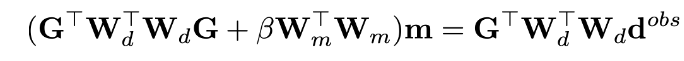

In [35]:
std = 0.01  # same as our noise level 
Wd = sp.spdiags([1/std*np.ones(n_kernels)], [0], n_kernels, n_kernels)

In [36]:
delta_x = np.diff(x_nodes) 
Wm = sp.spdiags([np.sqrt(delta_x)], [0], n_cells, n_cells)

In [39]:
beta = 1e4

H = (G.T @ Wd.T @ Wd @ G + beta * Wm.T @ Wm)
rhs = G.T @ Wd.T @ Wd @ dobs

mrec = np.linalg.solve(H, rhs)

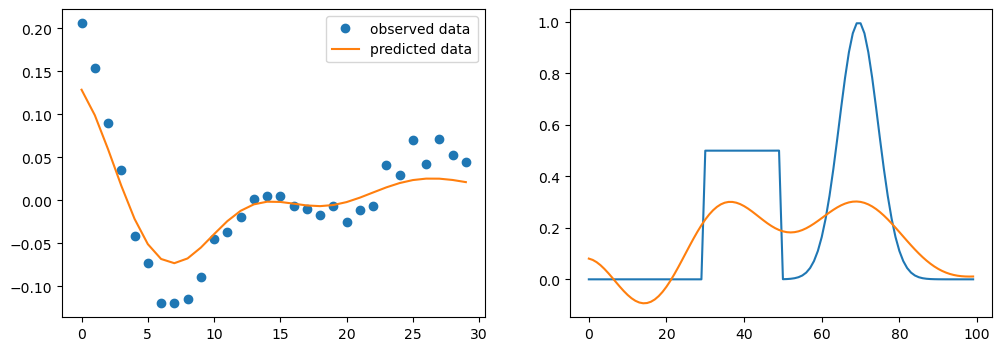

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(dobs, "o", label="observed data")
ax[0].plot(G @ mrec, "-", label="predicted data")

ax[1].plot(model)
ax[1].plot(mrec)

ax[0].legend()

In [50]:
def estimate_m(x_nodes, dobs, G, beta, std=0.01): 
    
    n_kernels = len(dobs)
    Wd = sp.spdiags([1/std*np.ones(n_kernels)], [0], n_kernels, n_kernels)

    delta_x = np.diff(x_nodes) 
    n_cells = len(x_nodes) - 1
    Ws = sp.spdiags([np.sqrt(delta_x)], [0], n_cells, n_cells)

    H = (G.T @ Wd.T @ Wd @ G + beta * Ws.T @ Ws)  # (G.T @ Wd.T @ Wd @ G + beta * (alpha_s * Ws.T @ Ws + alpha_x * Wx.T @ Wx))
    rhs = G.T @ Wd.T @ Wd @ dobs
    mrec = np.linalg.solve(H, rhs)

    dpred = G @ mrec

    residual = (dpred - dobs)
    phid = (Wd @ residual).T @ Wd @ residual 
    phim = (Wm @ mrec).T @ (Wm @ mrec)

    return mrec, dpred, phid, phim

In [51]:
# do a for loop over a range of beta values 

std = 0.01

n_betas = 100
beta_values = np.logspace(4, -4, n_betas)
phid = np.zeros(n_betas)
phim = np.zeros(n_betas)

mrecs = np.zeros((n_cells, n_betas))
dpreds = np.zeros((n_kernels, n_betas))

for i, beta in enumerate(beta_values): 
    mrecs[:, i], dpreds[:, i], phid[i], phim[i] = estimate_m(x_nodes, dobs, G, beta, std=std)
    

In [54]:
def plot_tikhonov_curves(beta_values, phid, phim, n_kernels=n_kernels, beta_index=0, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 4)) 
    
    ax[0].semilogx(beta_values, phid)
    ax[1].semilogx(beta_values, phim)
    ax[2].loglog(phim, phid) 

    # plot beta at the beta index
    ax[0].semilogx(beta_values[beta_index], phid[beta_index], "ro")
    ax[1].semilogx(beta_values[beta_index], phim[beta_index], "ro")
    ax[2].loglog(phim[beta_index], phid[beta_index], "ro")
    
    ax[0].set_ylabel("$\\phi_d$")
    ax[1].set_ylabel("$\\phi_m$")
    
    ax[2].set_xlabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    
    # add our target misfit 
    ax[0].semilogx(beta_values, np.ones(len(beta_values))*n_kernels, "--k")
    ax[2].loglog(phim, np.ones(len(phim))*n_kernels, "--k")
    
    for a in ax[:2]:
        a.invert_xaxis()
        a.set_xlabel("$\\beta$")
    plt.tight_layout()

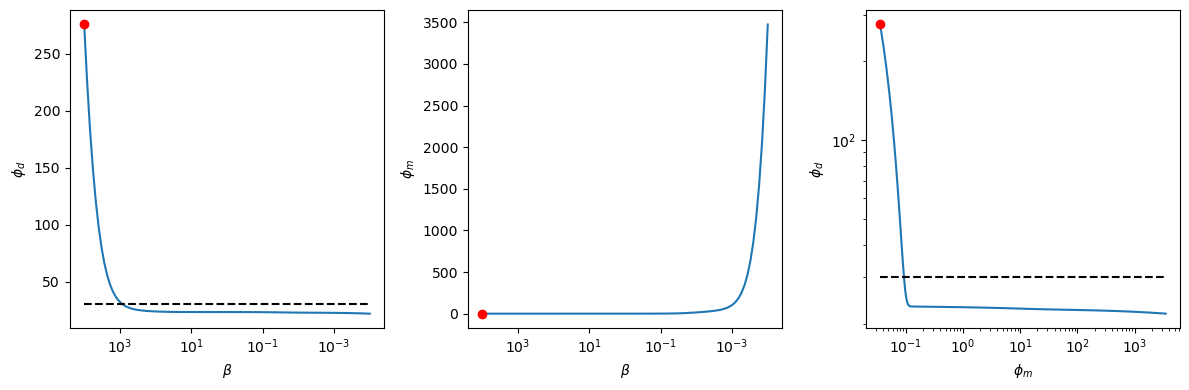

In [55]:
plot_tikhonov_curves(beta_values, phid, phim, n_kernels, beta_index=0, ax=None)

In [63]:
def plot_inversion_results(x_cells, G, model, mrecs, dobs, dpred, beta_index=0, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3)) 
    
    ax[0].plot(x_cells, G.T)
    
    # plot our observed data 
    ax[1].plot(dobs, "o", label="observed data")
    ax[1].plot(dpreds[:, beta_index], "-s", label="predicted data")
    
    ax[2].plot(x_cells, model, label="true model")
    ax[2].plot(x_cells, mrecs[:, beta_index], label="recovered model")
    
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("kernel value")
    
    ax[1].set_xlabel("data index")
    ax[1].set_ylabel("data value")
    
    ax[2].set_xlabel("x")
    ax[2].set_ylabel("model value")
    
    ax[1].legend()
    ax[2].legend()
    
    plt.tight_layout()

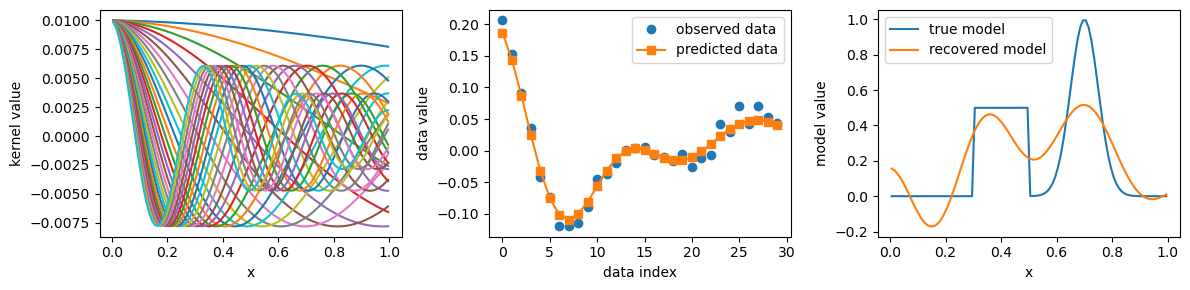

In [66]:
plot_inversion_results(x_cells, G, model, mrecs, dobs, dpreds, beta_index=10, ax=None)

In [71]:
def plot_all_results(beta_index=0): 
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    
    plot_tikhonov_curves(beta_values, phid, phim, n_kernels, beta_index=beta_index, ax=ax[0, :])
    plot_inversion_results(x_cells, G, model, mrecs, dobs, dpreds, beta_index=beta_index, ax=ax[1, :])

In [73]:
ipywidgets.interact(
    plot_all_results, 
    beta_index=ipywidgets.IntSlider(
        min=0, 
        max=n_betas-1,
        value=0
    )
)

interactive(children=(IntSlider(value=0, description='beta_index', max=99), Output()), _dom_classes=('widget-i…

<function __main__.plot_all_results(beta_index=0)>